In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet, CustomDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from sklearn.decomposition import PCA
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tikzplotlib
import torch
import os
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### PCA Analysis

#### PCA with All Features Data
In this case we consider the data associated with each path, BS, and charcteristic (the 6 features for each path) as a unique set of features of dimension 600.

In [2]:
# Load the dataset with all the paths
dir_name = "Omni Spatial and Temporal Data/"
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler, add_noise=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [3]:
# create the sk-learn PCA object and fit the training data
pca_all = PCA()
pca_all_components = pca_all.fit(train_set.X)

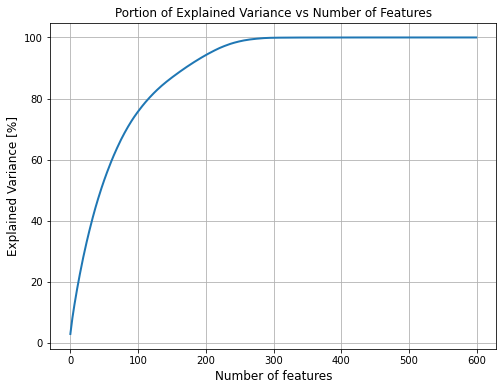

In [4]:
# let's visualize the amount of explained variance by increasing number of considered features
cum_explained_var = np.cumsum(pca_all_components.explained_variance_ratio_ * 100)
plt.figure(figsize=(8,6))
plt.plot(cum_explained_var, linewidth=2)
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Explained Variance [%]", fontsize=12)
plt.title("Portion of Explained Variance vs Number of Features")
plt.grid()

tikzplotlib.save("./figures/explained_variance_noise.tex")

In [5]:
# retain a number of features with which we can explain at least 95 % of the total variance
I = np.where(cum_explained_var >= 95)[0]
num_features_95 = I[0]
print(f"The number of features needed to explain 95 % of the variance is: {num_features_95}")

# create an sk-learn PCA object with the above number of components
pca_95 = PCA(n_components=I[0])
x_train_95 = pca_95.fit_transform(train_set.X)
x_test_95 = pca_95.transform(test_set.X)
print(f"The reduced training data has shape: {x_train_95.shape}")
print(f"The percentage of explained variance is: {np.sum(pca_95.explained_variance_ratio_)*100}")

# create data loaders with the nre reduced data
train_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_train_95, train_set.y), batch_size=32, shuffle=True)
test_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_test_95, test_set.y), batch_size=1024, shuffle=False)

The number of features needed to explain 95 % of the variance is: 207
The reduced training data has shape: (75000, 207)


#### PCA for each feature
In this case we consider the data associated with the 6 features (delay, rx power, and the 4 angles of arrival and departure).
Specifically, based on the PCA of the data matrix, we select the 3 features that have the highest explanation power in the dataset. Each feature has 100 singular values associated (25 paths x 4 Base Stations)

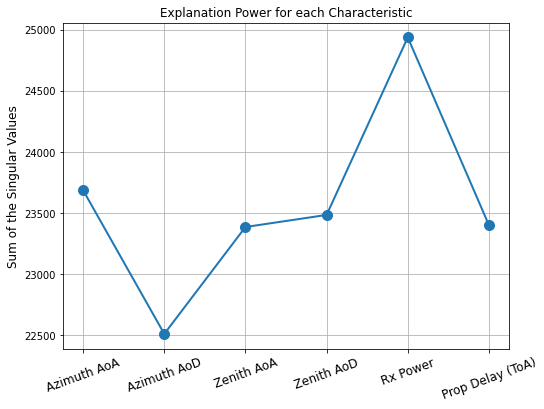

In [6]:
# we consider a PCA with 1 Principal Component to obtain the importance associated whith each characteristic
num_charac = 6
sinv_charac = np.zeros((num_charac, 1))
for i in range(num_charac):
    data = train_set.X[:, i*100:(i+1)*100]
    pca_i = PCA(100)
    pca_i_comp = pca_i.fit(data)
    sinv_charac[i] = np.sum(pca_i_comp.singular_values_)
    
plt.figure(figsize=(8,6))
plt.plot(sinv_charac, '-o', markersize=10, linewidth=2)
plt.ylabel("Sum of the Singular Values", fontsize=12)
plt.grid()
plt.title("Explanation Power for each Characteristic")
plt.xticks(np.arange(6), ["Azimuth AoA","Azimuth AoD","Zenith AoA","Zenith AoD","Rx Power","Prop Delay (ToA)"], rotation=20, fontsize=12)

tikzplotlib.save("./figures/characteristics_noise.tex")

From the plot above we can see that the 3 most important features are: Zenith AoD, Rx Power, and Propagation Delay.
Therefore, we will consider as input to our models the 100 samples (25x4) associated with these 3 characteristics, for a total of 300 features.

In [7]:
# get the full dataset
dir_name = "Omni Spatial and Temporal Data/"
full_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
(x_train, y_train), (x_test, y_test) = full_dataset.get_datasets(get_full_data=True, add_noise=True)

# selecting the feature corresponding to zenith AoD, Rx Power, and Propagation Delay (ToA) 
# [last 3 indexes in the right-most dimension]
x_train = np.reshape(x_train[:,:,:, [0,3,4]], (x_train.shape[0],x_train.shape[1]*x_train.shape[2]*3))
x_test = np.reshape(x_test[:,:,:,[0,3,4]], (x_test.shape[0],x_test.shape[1]*x_test.shape[2]*3))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
train_set = CustomDataSet(x_train, y_train)
test_set = CustomDataSet(x_test, y_test)

train_feature_based_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_feature_based_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)


## Train with the 95% variance explained features

In [8]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
summary(dnn_model_95, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_95.parameters(), lr=0.0001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              53,248
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 69,891
Trainable params: 69,891
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.27


In [9]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_95_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_95(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_95_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_95(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 18417.712609613307
Training at epoch: 2 ended, Loss: 7457.004778240321
Training at epoch: 3 ended, Loss: 5259.351973810293
Training at epoch: 4 ended, Loss: 4064.9918138419403
Training at epoch: 5 ended, Loss: 3414.426913160513
Training at epoch: 6 ended, Loss: 2969.792824963254
Training at epoch: 7 ended, Loss: 2678.6693354792155
Training at epoch: 8 ended, Loss: 2475.3182982356884
Training at epoch: 9 ended, Loss: 2317.6357872608173
Training at epoch: 10 ended, Loss: 2186.3373986983056
--> Testing at epoch: 10 ended, Loss: 3469.588106722445
Training at epoch: 11 ended, Loss: 2072.7145835173415
Training at epoch: 12 ended, Loss: 1970.4551748594733
Training at epoch: 13 ended, Loss: 1877.8889628856255
Training at epoch: 14 ended, Loss: 1803.407613318121
Training at epoch: 15 ended, Loss: 1732.1381789327888
Training at epoch: 16 ended, Loss: 1670.6270830981155
Training at epoch: 17 ended, Loss: 1625.0086736451237
Training at epoch: 18 ended, Loss: 1571.

--> Testing at epoch: 140 ended, Loss: 2289.9423663165117
Training at epoch: 141 ended, Loss: 430.33833468570646
Training at epoch: 142 ended, Loss: 428.9509854398083
Training at epoch: 143 ended, Loss: 426.4278039085987
Training at epoch: 144 ended, Loss: 435.4807211026397
Training at epoch: 145 ended, Loss: 514.1247709619307
Training at epoch: 146 ended, Loss: 418.7337244867058
Training at epoch: 147 ended, Loss: 443.3896915318616
Training at epoch: 148 ended, Loss: 468.2999783571263
Training at epoch: 149 ended, Loss: 413.00429449960234
Training at epoch: 150 ended, Loss: 412.4526522444377
--> Testing at epoch: 150 ended, Loss: 2202.679287059887
Training at epoch: 151 ended, Loss: 409.5232768530732
Training at epoch: 152 ended, Loss: 418.182002838968
Training at epoch: 153 ended, Loss: 407.3429808177232
Training at epoch: 154 ended, Loss: 412.04518426563146
Training at epoch: 155 ended, Loss: 402.37585907177714
Training at epoch: 156 ended, Loss: 401.81182720718124
Training at epoch

Training at epoch: 277 ended, Loss: 266.31455715849944
Training at epoch: 278 ended, Loss: 265.3686561128792
Training at epoch: 279 ended, Loss: 269.6031689725231
Training at epoch: 280 ended, Loss: 264.61541161846384
--> Testing at epoch: 280 ended, Loss: 1590.972285090266
Training at epoch: 281 ended, Loss: 323.3867891982147
Training at epoch: 282 ended, Loss: 262.12874381289953
Training at epoch: 283 ended, Loss: 260.15158936757683
Training at epoch: 284 ended, Loss: 260.9390156781714
Training at epoch: 285 ended, Loss: 264.33927011327125
Training at epoch: 286 ended, Loss: 258.69214066059516
Training at epoch: 287 ended, Loss: 290.9414837514988
Training at epoch: 288 ended, Loss: 256.8525882499617
Training at epoch: 289 ended, Loss: 257.7475038697695
Training at epoch: 290 ended, Loss: 259.10770821164493
--> Testing at epoch: 290 ended, Loss: 1652.0009617161106
Training at epoch: 291 ended, Loss: 258.49171914500994
Training at epoch: 292 ended, Loss: 256.8846897248929
Training at e

Training at epoch: 413 ended, Loss: 204.16950044534312
Training at epoch: 414 ended, Loss: 329.8157242882374
Training at epoch: 415 ended, Loss: 213.53695476746805
Training at epoch: 416 ended, Loss: 201.82860303657455
Training at epoch: 417 ended, Loss: 202.76383785501682
Training at epoch: 418 ended, Loss: 206.1068568799276
Training at epoch: 419 ended, Loss: 202.2636219307831
Training at epoch: 420 ended, Loss: 202.9866782129828
--> Testing at epoch: 420 ended, Loss: 1542.5362911739865
Training at epoch: 421 ended, Loss: 203.38335004682833
Training at epoch: 422 ended, Loss: 202.58101738679125
Training at epoch: 423 ended, Loss: 205.1550008998389
Training at epoch: 424 ended, Loss: 201.3450187530127
Training at epoch: 425 ended, Loss: 200.9505196968443
Training at epoch: 426 ended, Loss: 200.20590014018296
Training at epoch: 427 ended, Loss: 201.08851023176018
Training at epoch: 428 ended, Loss: 202.4529744626719
Training at epoch: 429 ended, Loss: 199.89091477215086
Training at epo

In [10]:
torch.save(dnn_model_95.state_dict(), "../models/dnn_model_95_v1_noise")

In [11]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
dnn_model_95.load_state_dict(torch.load("../models/dnn_model_95_v1_noise"))

# evaluate the model over the entire data and the test data
train_error_95 = []
test_error_95 = []
all_error_95 = []

for xx, yy in train_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_95.extend(error)
    all_error_95.extend(error)

for xx, yy in test_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_95.extend(error)
    test_error_95.extend(error)

train_error_95 = np.array(train_error_95)
test_error_95 = np.array(test_error_95)
all_error_95 = np.array(all_error_95)

## Train over the 3 most relevant carachteristics

In [12]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
summary(dnn_model_3, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_3.parameters(), lr=0.0001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              77,056
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 93,699
Trainable params: 93,699
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36


In [13]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_feature_based_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_3(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_feature_based_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_3(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 13797.517409080532
Training at epoch: 2 ended, Loss: 4592.669944424678
Training at epoch: 3 ended, Loss: 3142.6004882916654
Training at epoch: 4 ended, Loss: 2521.227434334088
Training at epoch: 5 ended, Loss: 2111.319586327458
Training at epoch: 6 ended, Loss: 1856.0857720488982
Training at epoch: 7 ended, Loss: 1678.008859549773
Training at epoch: 8 ended, Loss: 1543.4888179635839
Training at epoch: 9 ended, Loss: 1442.7384143608015
Training at epoch: 10 ended, Loss: 1363.211380213194
--> Testing at epoch: 10 ended, Loss: 4608.817854597762
Training at epoch: 11 ended, Loss: 1295.2475344817385
Training at epoch: 12 ended, Loss: 1237.2243062693105
Training at epoch: 13 ended, Loss: 1184.8197575852325
Training at epoch: 14 ended, Loss: 1138.57719438312
Training at epoch: 15 ended, Loss: 1100.3295786014596
Training at epoch: 16 ended, Loss: 1066.2448130142159
Training at epoch: 17 ended, Loss: 1035.9842735589975
Training at epoch: 18 ended, Loss: 1005.59

--> Testing at epoch: 140 ended, Loss: 4635.030382104822
Training at epoch: 141 ended, Loss: 219.64373918279446
Training at epoch: 142 ended, Loss: 233.74667666145558
Training at epoch: 143 ended, Loss: 227.08976491563556
Training at epoch: 144 ended, Loss: 219.04918558361587
Training at epoch: 145 ended, Loss: 212.75441856026242
Training at epoch: 146 ended, Loss: 214.35521259893736
Training at epoch: 147 ended, Loss: 228.88751994871848
Training at epoch: 148 ended, Loss: 214.2922450470843
Training at epoch: 149 ended, Loss: 204.93645266542663
Training at epoch: 150 ended, Loss: 205.49096904110175
--> Testing at epoch: 150 ended, Loss: 4448.693229675293
Training at epoch: 151 ended, Loss: 214.860061793604
Training at epoch: 152 ended, Loss: 200.42324107010617
Training at epoch: 153 ended, Loss: 210.02793304993432
Training at epoch: 154 ended, Loss: 209.68576491570718
Training at epoch: 155 ended, Loss: 207.41951974666972
Training at epoch: 156 ended, Loss: 197.13409328948921
Training 

Training at epoch: 277 ended, Loss: 102.71180732258351
Training at epoch: 278 ended, Loss: 94.70908876327931
Training at epoch: 279 ended, Loss: 95.8126853602738
Training at epoch: 280 ended, Loss: 112.40157374342961
--> Testing at epoch: 280 ended, Loss: 6026.215529570708
Training at epoch: 281 ended, Loss: 108.92540575782594
Training at epoch: 282 ended, Loss: 97.30701076618233
Training at epoch: 283 ended, Loss: 102.86089163103202
Training at epoch: 284 ended, Loss: 92.92583223251759
Training at epoch: 285 ended, Loss: 129.04519096291511
Training at epoch: 286 ended, Loss: 108.01909622885668
Training at epoch: 287 ended, Loss: 90.6916049918217
Training at epoch: 288 ended, Loss: 90.95408412295397
Training at epoch: 289 ended, Loss: 91.55666800407826
Training at epoch: 290 ended, Loss: 110.60034999831137
--> Testing at epoch: 290 ended, Loss: 6198.566052823453
Training at epoch: 291 ended, Loss: 90.74605047662104
Training at epoch: 292 ended, Loss: 90.31414507599007
Training at epoch

Training at epoch: 414 ended, Loss: 78.36303420319085
Training at epoch: 415 ended, Loss: 60.45849294955413
Training at epoch: 416 ended, Loss: 60.40209961425729
Training at epoch: 417 ended, Loss: 60.99882246650527
Training at epoch: 418 ended, Loss: 66.50181972777071
Training at epoch: 419 ended, Loss: 59.556065364502395
Training at epoch: 420 ended, Loss: 59.56987768920209
--> Testing at epoch: 420 ended, Loss: 4614.541784956648
Training at epoch: 421 ended, Loss: 60.888136261152326
Training at epoch: 422 ended, Loss: 64.42014996997325
Training at epoch: 423 ended, Loss: 67.44374771248359
Training at epoch: 424 ended, Loss: 60.05376094152496
Training at epoch: 425 ended, Loss: 67.08633339811918
Training at epoch: 426 ended, Loss: 59.27805161679564
Training at epoch: 427 ended, Loss: 60.436431086917786
Training at epoch: 428 ended, Loss: 59.84949772471861
Training at epoch: 429 ended, Loss: 58.67540540833522
Training at epoch: 430 ended, Loss: 58.262597635337514
--> Testing at epoch:

In [14]:
torch.save(dnn_model_3.state_dict(), "../models/dnn_model_3_v1_noise")

In [15]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
dnn_model_3.load_state_dict(torch.load("../models/dnn_model_3_v1_noise"))

# evaluate the model over the entire data and the test data
train_error_3 = []
test_error_3 = []
all_error_3 = []

for xx, yy in train_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_3.extend(error)
    all_error_3.extend(error)

for xx, yy in test_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_3.extend(error)
    test_error_3.extend(error)

train_error_3 = np.array(train_error_3)
test_error_3 = np.array(test_error_3)
all_error_3 = np.array(all_error_3)

### Results

In [16]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated_noise.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [17]:
#hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
#print(hashim_baseline.shape)

(150000,)


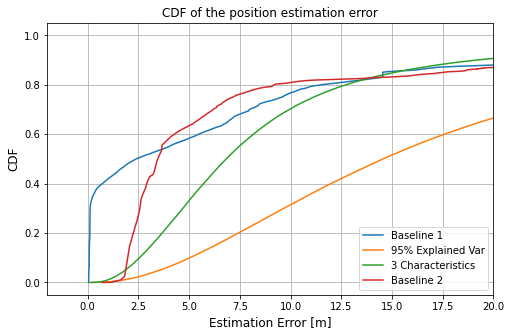

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error_95), np.linspace(0,1,len(all_error_95)), 
       np.sort(all_error_3), np.linspace(0,1,len(all_error_3)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")

plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "95% Explained Var", "3 Characteristics", "Baseline 2"], loc="lower right")

tikzplotlib.save("./figures/pca_95_3charac_vs_baselines_noise.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [19]:
# print(f"The average error for the Baseline is {np.mean(baseline_error)}")
# print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
# print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
# print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

In [20]:
baseline_err_sort = np.sort(baseline_error)
y = np.linspace(0,1.0,len(baseline_err_sort))
print(f"BASELINE 1: the 80% percentile error in meters is {baseline_err_sort[y>=0.8][0]}")

baseline_hash_sort = np.sort(hashim_baseline)
y = np.linspace(0,1.0,len(baseline_hash_sort))
print(f"BASELINE 2: the 80% percentile error in meters is {baseline_hash_sort[y>=0.8][0]}")

all_error_95_sort = np.sort(all_error_95)
y = np.linspace(0,1.0,len(all_error_95_sort))
print(f"95% Explained: the 80% percentile error in meters is {all_error_95_sort[y>=0.8][0]}")

all_error_3_sort = np.sort(all_error_3)
y = np.linspace(0,1.0,len(all_error_3_sort))
print(f"3 CHARACT: the 80% percentile error in meters is {all_error_3_sort[y>=0.8][0]}")


BASELINE 1: the 80% percentile error in meters is 11.510478518139134
BASELINE 2: the 80% percentile error in meters is 9.194424085538204
95% Explained: the 80% percentile error in meters is 27.2672061920166
3 CHARACT: the 80% percentile error in meters is 12.722270965576172
